In [1]:
# %pip install --upgrade catboost
# %pip install --upgrade ipywidgets
# %pip install shap
# %pip install sklearn

In [2]:
import os
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

import catboost
print(catboost.__version__)

1.1.1


In [3]:
from catboost.datasets import amazon

train_df, test_df = amazon()

In [4]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [5]:
y = train_df.ACTION
X = train_df.drop("ACTION", axis=1)

In [6]:
cat_features = list(range(0, X.shape[1]))
cat_features

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [7]:
print(f"Labels: {set(y)}")
print(f"Zero count = {len(y) - sum(y)}, One count = {sum(y)}")

Labels: {0, 1}
Zero count = 1897, One count = 30872


In [8]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=100)
model.fit(X, y, cat_features=cat_features, verbose=10)

Learning rate set to 0.377604
0:	learn: 0.4528598	total: 172ms	remaining: 17s
10:	learn: 0.1744186	total: 660ms	remaining: 5.34s
20:	learn: 0.1676119	total: 1.2s	remaining: 4.51s
30:	learn: 0.1652446	total: 1.71s	remaining: 3.81s
40:	learn: 0.1633644	total: 2.19s	remaining: 3.16s
50:	learn: 0.1621892	total: 2.68s	remaining: 2.58s
60:	learn: 0.1609164	total: 3.2s	remaining: 2.05s
70:	learn: 0.1594572	total: 3.73s	remaining: 1.52s
80:	learn: 0.1585876	total: 4.26s	remaining: 1s
90:	learn: 0.1573593	total: 4.82s	remaining: 477ms
99:	learn: 0.1566977	total: 5.29s	remaining: 0us


In [9]:
model.predict_proba(X)

array([[0.0098, 0.9902],
       [0.0101, 0.9899],
       [0.0579, 0.9421],
       ...,
       [0.0118, 0.9882],
       [0.1891, 0.8109],
       [0.0235, 0.9765]])

In [10]:
from catboost import Pool
pool = Pool(data=X, label=y, cat_features=cat_features)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)

In [12]:
model = CatBoostClassifier(iterations=5, learning_rate=0.1, loss_function="Logloss")
model.fit(train_pool, eval_set=val_pool, verbose=False)

print(f"Model is fitted: {model.is_fitted()}")
print(f"Model params: {model.get_params()}")

Model is fitted: True
Model params: {'iterations': 5, 'learning_rate': 0.1, 'loss_function': 'Logloss'}


In [13]:
model = CatBoostClassifier(iterations=15)
model.fit(train_pool, eval_set=val_pool)

Learning rate set to 0.441257
0:	learn: 0.4226231	test: 0.4217069	best: 0.4217069 (0)	total: 42.5ms	remaining: 595ms
1:	learn: 0.3157972	test: 0.3136469	best: 0.3136469 (1)	total: 94.1ms	remaining: 612ms
2:	learn: 0.2631196	test: 0.2603395	best: 0.2603395 (2)	total: 137ms	remaining: 548ms
3:	learn: 0.2334650	test: 0.2294580	best: 0.2294580 (3)	total: 183ms	remaining: 503ms
4:	learn: 0.2077060	test: 0.2017327	best: 0.2017327 (4)	total: 232ms	remaining: 464ms
5:	learn: 0.1961364	test: 0.1883112	best: 0.1883112 (5)	total: 283ms	remaining: 425ms
6:	learn: 0.1879266	test: 0.1794018	best: 0.1794018 (6)	total: 330ms	remaining: 377ms
7:	learn: 0.1841218	test: 0.1743149	best: 0.1743149 (7)	total: 361ms	remaining: 316ms
8:	learn: 0.1814626	test: 0.1698731	best: 0.1698731 (8)	total: 410ms	remaining: 274ms
9:	learn: 0.1785403	test: 0.1650335	best: 0.1650335 (9)	total: 457ms	remaining: 229ms
10:	learn: 0.1771678	test: 0.1634002	best: 0.1634002 (10)	total: 509ms	remaining: 185ms
11:	learn: 0.1762101

In [14]:
model = CatBoostClassifier(iterations=50, learning_rate=0.5, custom_loss=["AUC", "Accuracy"])

model.fit(train_pool, eval_set=val_pool, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [15]:
model1 = CatBoostClassifier(iterations=100, learning_rate=0.7, train_dir="learning_rate_0.7")

model2 = CatBoostClassifier(iterations=100, learning_rate=0.01, train_dir="learning_rate_0.01")

model1.fit(train_pool, eval_set=val_pool, verbose=20)
model2.fit(train_pool, eval_set=val_pool, verbose=20)

0:	learn: 0.3264513	test: 0.3248170	best: 0.3248170 (0)	total: 39.9ms	remaining: 3.95s
20:	learn: 0.1688825	test: 0.1574182	best: 0.1573949 (16)	total: 1.32s	remaining: 4.97s
40:	learn: 0.1632884	test: 0.1582531	best: 0.1571533 (23)	total: 2.47s	remaining: 3.56s
60:	learn: 0.1584388	test: 0.1573279	best: 0.1569712 (52)	total: 3.56s	remaining: 2.27s
80:	learn: 0.1544282	test: 0.1583794	best: 0.1569712 (52)	total: 4.62s	remaining: 1.08s
99:	learn: 0.1510415	test: 0.1583995	best: 0.1569712 (52)	total: 5.61s	remaining: 0us

bestTest = 0.1569712214
bestIteration = 52

Shrink model to first 53 iterations.
0:	learn: 0.6853769	test: 0.6853610	best: 0.6853610 (0)	total: 40.6ms	remaining: 4.02s
20:	learn: 0.5575578	test: 0.5568257	best: 0.5568257 (20)	total: 854ms	remaining: 3.21s
40:	learn: 0.4678112	test: 0.4663769	best: 0.4663769 (40)	total: 1.65s	remaining: 2.38s
60:	learn: 0.4029225	test: 0.4011544	best: 0.4011544 (60)	total: 2.36s	remaining: 1.51s
80:	learn: 0.3551621	test: 0.3530433	best:

In [16]:
from catboost import MetricVisualizer
MetricVisualizer(["learning_rate_0.7", "learning_rate_0.01"]).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [17]:
model = CatBoostClassifier(iterations=100,
# use_best_model=False if you don't want to throw away the trees after the best iteration
)

model.fit(train_pool, eval_set=val_pool, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [18]:
print(f"Tree count: {model.tree_count_}")

Tree count: 82


In [23]:
from catboost import cv  # Cross-validation

params = {
    "loss_function": "Logloss",
    "iterations": 80,
    "custom_loss": "AUC",
    "learning_rate": 0.5
}

cv_data = cv(params=params, pool=train_pool, fold_count=5, shuffle=True, partition_random_seed=0, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1633673021
bestIteration = 43

Training on fold [1/5]

bestTest = 0.1608272543
bestIteration = 77

Training on fold [2/5]

bestTest = 0.1694535356
bestIteration = 12

Training on fold [3/5]

bestTest = 0.1569121503
bestIteration = 70

Training on fold [4/5]

bestTest = 0.1644437541
bestIteration = 30



In [24]:
cv_data.head(10)

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.305831,0.000020,0.305810,0.000014,0.496175,0.014042
1,1,0.234755,0.001020,0.235427,0.000274,0.569789,0.030202
2,2,0.195174,0.002570,0.201798,0.002884,0.769422,0.023153
3,3,0.182194,0.001790,0.190833,0.001257,0.799230,0.004934
4,4,0.175112,0.001397,0.185044,0.001841,0.814287,0.009233
5,5,0.171637,0.002118,0.182109,0.001647,0.821699,0.006934
6,6,0.170182,0.001856,0.180271,0.002270,0.826122,0.006897
7,7,0.168447,0.002045,0.178166,0.002201,0.832107,0.009408
8,8,0.167530,0.002314,0.176640,0.002292,0.834131,0.009651
9,9,0.166555,0.002901,0.174878,0.002130,0.836757,0.010955


In [25]:
best_value = np.min(cv_data["test-Logloss-mean"])
best_iter = np.argmin(cv_data["test-Logloss-mean"])

print(f"Best validation Logloss score, not stratified: {best_value:.4f}+-{cv_data['test-Logloss-std'][best_iter]} on step {best_iter}")

Best validation Logloss score, not stratified: 0.1640+-0.004490347970503274 on step 32


In [26]:
from catboost import cv  # Cross-validation

params = {
    "loss_function": "Logloss",
    "iterations": 80,
    "custom_loss": "AUC",
    "learning_rate": 0.5
}

cv_data = cv(params=params, pool=train_pool, fold_count=5, shuffle=True, partition_random_seed=0, plot=True, stratified=False, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1524159074
bestIteration = 40

Training on fold [1/5]

bestTest = 0.1702343283
bestIteration = 58

Training on fold [2/5]

bestTest = 0.1652713561
bestIteration = 49

Training on fold [3/5]

bestTest = 0.1506211193
bestIteration = 37

Training on fold [4/5]

bestTest = 0.1693370995
bestIteration = 41



In [27]:
cv_data.head(10)

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.305844,0.003462,0.305806,0.002034,0.504277,0.012652
1,1,0.234823,0.006785,0.235401,0.002418,0.565498,0.020208
2,2,0.196265,0.009054,0.202222,0.003174,0.762065,0.022580
3,3,0.182340,0.008920,0.190595,0.002653,0.800348,0.015398
4,4,0.174199,0.008397,0.183848,0.002923,0.821240,0.011202
5,5,0.171801,0.008946,0.181284,0.003386,0.824134,0.011407
6,6,0.169380,0.009416,0.179020,0.003022,0.831212,0.015047
7,7,0.168108,0.009746,0.177513,0.003095,0.833586,0.016659
8,8,0.167554,0.009951,0.176260,0.002762,0.834448,0.017402
9,9,0.166717,0.010568,0.175005,0.002365,0.836850,0.018530


In [28]:
best_value = np.min(cv_data["test-Logloss-mean"])
best_iter = np.argmin(cv_data["test-Logloss-mean"])

print(f"Best validation Logloss score, not stratified: {best_value:.4f}+-{cv_data['test-Logloss-std'][best_iter]} on step {best_iter}")

Best validation Logloss score, not stratified: 0.1619+-0.009516055324516834 on step 39


In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {"learning_rate": [0.001, 0.01, 0.5]}

clf = CatBoostClassifier(iterations=20, cat_features=cat_features, verbose=20)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3)
results = grid_search.fit(X_train, y_train)
results.best_estimator_.get_params()

0:	learn: 0.6923673	total: 24.7ms	remaining: 469ms
19:	learn: 0.6778431	total: 624ms	remaining: 0us
0:	learn: 0.6923682	total: 25.9ms	remaining: 492ms
19:	learn: 0.6778558	total: 537ms	remaining: 0us
0:	learn: 0.6923682	total: 24.6ms	remaining: 467ms
19:	learn: 0.6778568	total: 541ms	remaining: 0us
0:	learn: 0.6853838	total: 30ms	remaining: 571ms
19:	learn: 0.5629769	total: 604ms	remaining: 0us
0:	learn: 0.6853928	total: 30.1ms	remaining: 572ms
19:	learn: 0.5630657	total: 623ms	remaining: 0us
0:	learn: 0.6853925	total: 26.6ms	remaining: 506ms
19:	learn: 0.5630556	total: 889ms	remaining: 0us
0:	learn: 0.3972934	total: 33ms	remaining: 627ms
19:	learn: 0.1766459	total: 1.12s	remaining: 0us
0:	learn: 0.3977266	total: 31.7ms	remaining: 602ms
19:	learn: 0.1774892	total: 1.12s	remaining: 0us
0:	learn: 0.3977128	total: 37.9ms	remaining: 721ms
19:	learn: 0.1733642	total: 1.17s	remaining: 0us
0:	learn: 0.3971379	total: 45.3ms	remaining: 862ms
19:	learn: 0.1717590	total: 1.22s	remaining: 0us


{'iterations': 20,
 'learning_rate': 0.5,
 'verbose': 20,
 'cat_features': [0, 1, 2, 3, 4, 5, 6, 7, 8]}

In [30]:
model_with_early_stop = CatBoostClassifier(iterations=200, learning_rate=0.5, early_stopping_rounds=20)  # Stop if no improvement for 20 iterations

model_with_early_stop.fit(train_pool, eval_set=val_pool, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [31]:
print(model_with_early_stop.tree_count_)

20


In [32]:
model_with_early_stop = CatBoostClassifier(eval_metric="AUC", iterations=200, learning_rate=0.5, early_stopping_rounds=20)  # eval_metric used for early stopping and selection of best iteration

model_with_early_stop.fit(train_pool, eval_set=val_pool, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [33]:
print(model_with_early_stop.tree_count_)

47


In [36]:
model = CatBoostClassifier(iterations=200, learning_rate=0.03)
model.fit(train_pool, verbose=50)

0:	learn: 0.6569432	total: 62.5ms	remaining: 12.4s
50:	learn: 0.1945392	total: 3.08s	remaining: 9s
100:	learn: 0.1651978	total: 6.96s	remaining: 6.82s
150:	learn: 0.1586149	total: 11.5s	remaining: 3.74s
199:	learn: 0.1550123	total: 15.8s	remaining: 0us


In [37]:
model.predict(X_val)  # Don't use (0.5 border)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [38]:
model.predict_proba(X_val)  # Maybe better to select own border

array([[0.0259, 0.9741],
       [0.0225, 0.9775],
       [0.0108, 0.9892],
       ...,
       [0.0346, 0.9654],
       [0.0347, 0.9653],
       [0.0214, 0.9786]])

In [39]:
raw_pred = model.predict(X_val, prediction_type="RawFormulaVal")  # RawFormulaVal is the sum of the trees, not probability (not between 0 and 1)
raw_pred

array([3.6272, 3.7712, 4.5153, ..., 3.3292, 3.3257, 3.824 ])

In [40]:
from numpy import exp

sigmoid = lambda x: 1 / (1 + exp(-x))

probabilities = sigmoid(raw_pred)

probabilities  # Between 0 and 1, the same as the right column of predict_proba

array([0.9741, 0.9775, 0.9892, ..., 0.9654, 0.9653, 0.9786])

In [41]:
import matplotlib.pyplot as plt
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

curve = get_roc_curve(model, val_pool)
fpr, tpr, threshold = curve

thresholds, fpr = get_fpr_curve(curve=curve)
thresholds, fnr = get_fnr_curve(curve=curve)

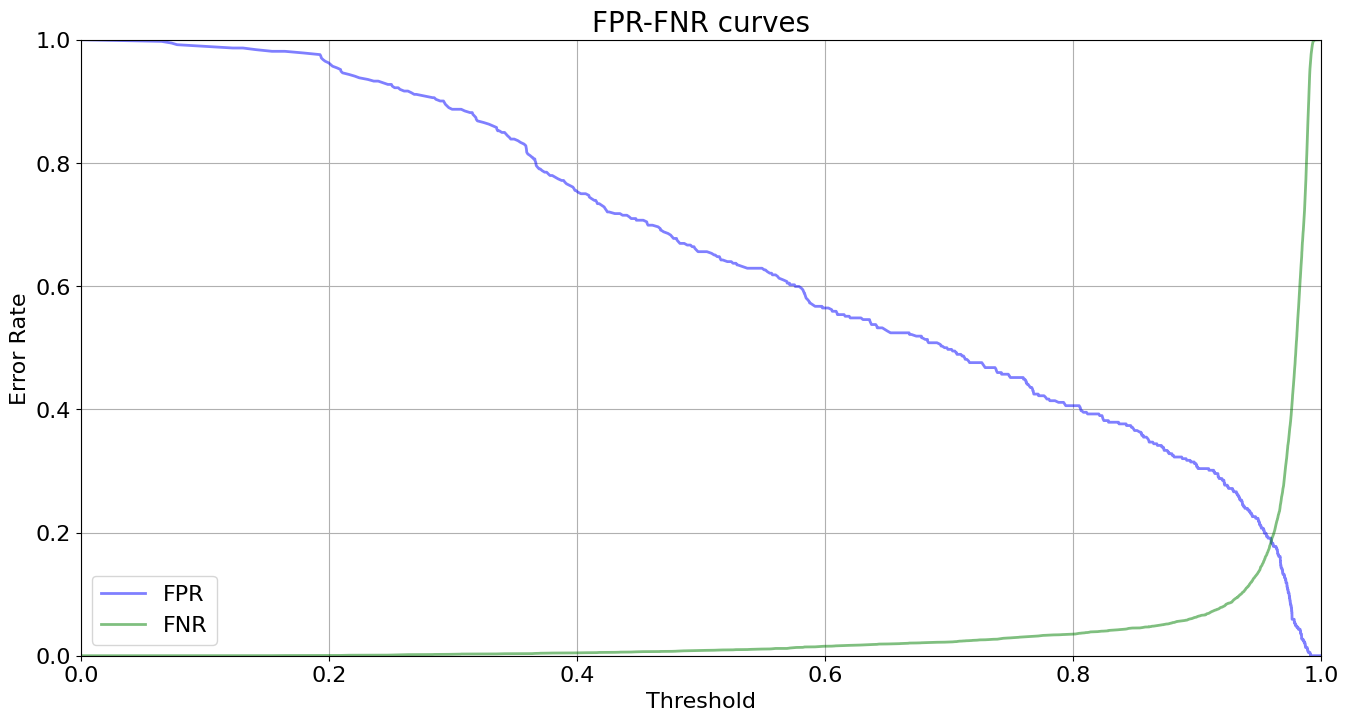

In [42]:
plt.figure(figsize=(16, 8))
style = {"alpha": 0.5, "lw": 2}

plt.plot(thresholds, fpr, color="blue", label="FPR", **style)
plt.plot(thresholds, fnr, color="green", label="FNR", **style)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel("Threshold", fontsize=16)
plt.ylabel("Error Rate", fontsize=16)
plt.title("FPR-FNR curves", fontsize=20)
plt.legend(loc="lower left", fontsize=16)

In [43]:
from catboost.utils import select_threshold

print(select_threshold(model, val_pool, FNR=0.01))
print(select_threshold(model, val_pool, FPR=0.01))

0.5292270290172643
0.9894800094413899


In [44]:
metrics = model.eval_metrics(data=val_pool, metrics=["Logloss", "AUC"], ntree_start=0, ntree_end=0, eval_period=1, plot=True)  # eval_period on which iteration you evaluate the metric

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [45]:
print(f"AUC values:\n{np.array(metrics['AUC'])}")

AUC values:
[0.5509 0.6273 0.6273 0.6279 0.6264 0.6262 0.6579 0.6579 0.6581 0.6581
 0.6561 0.656  0.6562 0.6535 0.6534 0.6541 0.6562 0.6544 0.6576 0.6642
 0.677  0.6842 0.7073 0.7142 0.714  0.714  0.7288 0.7502 0.7651 0.7786
 0.7862 0.7933 0.7933 0.7956 0.8026 0.8111 0.8147 0.8176 0.8214 0.8249
 0.8279 0.8291 0.8315 0.8348 0.8356 0.8361 0.8365 0.8379 0.8387 0.8409
 0.842  0.8434 0.8437 0.8444 0.8444 0.8446 0.8459 0.8472 0.8475 0.8478
 0.8479 0.8484 0.8487 0.8494 0.8495 0.8507 0.8508 0.8512 0.8511 0.8507
 0.8509 0.8513 0.8516 0.8527 0.8531 0.8536 0.8537 0.8543 0.857  0.8603
 0.8602 0.8633 0.8647 0.8675 0.8699 0.8719 0.8738 0.8753 0.8769 0.8785
 0.8802 0.881  0.8817 0.8829 0.8835 0.8843 0.8851 0.8857 0.8859 0.8866
 0.8872 0.8877 0.888  0.8885 0.8889 0.889  0.8894 0.8895 0.8897 0.8898
 0.8898 0.8899 0.8904 0.8905 0.8908 0.891  0.891  0.891  0.8911 0.8915
 0.8916 0.8918 0.892  0.8919 0.8922 0.8923 0.8923 0.8924 0.8926 0.8929
 0.8931 0.8932 0.8934 0.8935 0.8934 0.8934 0.8936 0.8937 0.8938 0

In [48]:
# How much does the prediction change if you change the feature?
np.array(model.get_feature_importance(prettified=True))  # percentage of importance, for ranking might be misleading

array([['RESOURCE', 22.83186926477892],
       ['MGR_ID', 18.35660787347638],
       ['ROLE_DEPTNAME', 16.109372900399883],
       ['ROLE_CODE', 9.01028208704679],
       ['ROLE_FAMILY_DESC', 8.615941542889209],
       ['ROLE_ROLLUP_2', 8.509112048240725],
       ['ROLE_TITLE', 7.49192742868466],
       ['ROLE_FAMILY', 5.03620157183847],
       ['ROLE_ROLLUP_1', 4.038685282644939]], dtype=object)

In [46]:
# How much does the loss change if you remove the feature? Works well everything including ranking, but takes a lot of time. If negative, should maybe be removed. Beware of removing something if not so many iterations! (Can be underfit)
np.array(model.get_feature_importance(train_pool, "LossFunctionChange", prettified=True))

array([['RESOURCE', 0.020614671360001814],
       ['MGR_ID', 0.018423619221202944],
       ['ROLE_CODE', 0.01001103779644197],
       ['ROLE_DEPTNAME', 0.009494386908765154],
       ['ROLE_FAMILY_DESC', 0.007626374272788652],
       ['ROLE_ROLLUP_2', 0.00323242436544153],
       ['ROLE_TITLE', 0.002297297516147539],
       ['ROLE_ROLLUP_1', 0.001025894676101658],
       ['ROLE_FAMILY', 0.0005901705433282561]], dtype=object)

In [47]:
print(model.predict_proba([X.iloc[1,:]]))
print(model.predict_proba([X.iloc[91,:]]))

[[0.0109 0.9891]]
[[0.5272 0.4728]]


In [49]:
shap_values = model.get_feature_importance(val_pool, "ShapValues")
expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]
shap_values.shape

(6554, 9)

In [50]:
proba = model.predict_proba([X.iloc[1, :]])[0]
raw = model.predict([X.iloc[1, :]], prediction_type="RawFormulaVal")[0]
print(f"Probabilities {proba}")
print(f"Raw formula value {raw:.4f}")
print(f"Probability from raw value {sigmoid(raw):.4f}")

Probabilities [0.0109 0.9891]
Raw formula value 4.5116
Probability from raw value 0.9891


In [51]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[1, :], X_val.iloc[1, :])

In [52]:
proba = model.predict_proba([X.iloc[91, :]])[0]
raw = model.predict([X.iloc[91, :]], prediction_type="RawFormulaVal")[0]
print(f"Probabilities {proba}")
print(f"Raw formula value {raw:.4f}")
print(f"Probability from raw value {sigmoid(raw):.4f}")

Probabilities [0.5272 0.4728]
Raw formula value -0.1087
Probability from raw value 0.4728


In [53]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[91, :], X_val.iloc[91, :])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


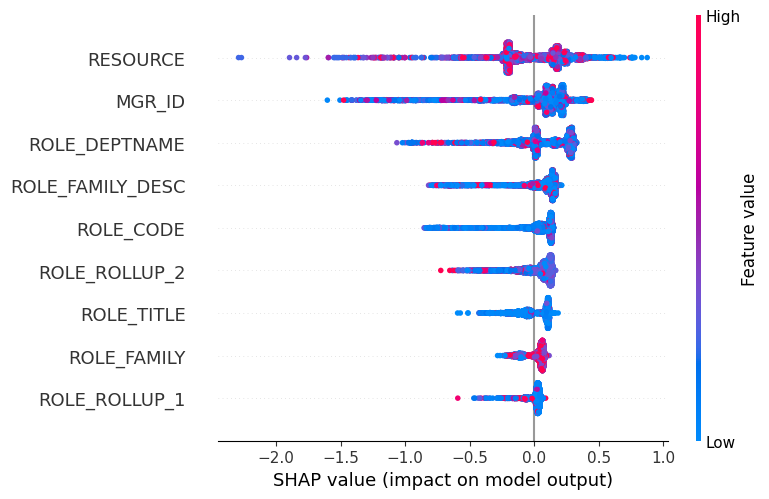

In [54]:
shap.summary_plot(shap_values, X_val)

In [61]:
# !rm "catboost_info/snapshot.bkp"

model = CatBoostClassifier(iterations=100, save_snapshot=True, snapshot_file="snapshot.bkp", snapshot_interval=1)

model.fit(train_pool, eval_set=val_pool, verbose=10)

Learning rate set to 0.193326
40:	learn: 0.1730095	test: 0.1605745	best: 0.1605745 (40)	total: 2.61s	remaining: 4.36s
50:	learn: 0.1712531	test: 0.1592140	best: 0.1592140 (50)	total: 3.31s	remaining: 3.53s
60:	learn: 0.1699903	test: 0.1583589	best: 0.1583589 (60)	total: 3.98s	remaining: 2.73s
70:	learn: 0.1696087	test: 0.1582369	best: 0.1582042 (66)	total: 4.64s	remaining: 1.99s
80:	learn: 0.1681471	test: 0.1573081	best: 0.1573081 (80)	total: 5.27s	remaining: 1.28s
90:	learn: 0.1673316	test: 0.1575898	best: 0.1573067 (81)	total: 5.92s	remaining: 604ms
99:	learn: 0.1668035	test: 0.1574311	best: 0.1573067 (81)	total: 6.5s	remaining: 0us

bestTest = 0.1573067324
bestIteration = 81

Shrink model to first 82 iterations.


In [63]:
model = CatBoostClassifier(iterations=10)
model.fit(train_pool, eval_set=val_pool, verbose=False)
model.save_model("catboost_model.bin")
model.save_model("catboost_model.json", format="json")

In [64]:
model.load_model("catboost_model.bin")
print(model.get_params())
print(model.learning_rate_)

{'iterations': 10, 'loss_function': 'Logloss', 'verbose': 0}
0.5


In [65]:
tuned_model = CatBoostClassifier(iterations=1000, learning_rate=0.03, depth=6, l2_leaf_reg=3, random_strength=1, bagging_temperature=1)

tuned_model.fit(X_train, y_train, cat_features=cat_features, verbose=False, eval_set=(X_val, y_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [66]:
fast_model = CatBoostClassifier(boosting_type="Plain", rsm=0.5, one_hot_max_size=50, leaf_estimation_iterations=1, max_ctr_complexity=1, iterations=100, learning_rate=0.3, bootstrap_type="Bernoulli", subsample=0.5)

fast_model.fit(X_train, y_train, cat_features=cat_features, verbose=False, eval_set=(X_val, y_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [67]:
small_model = CatBoostClassifier(max_ctr_complexity=1, iterations=500, learning_rate=0.03, model_size_reg=50, ctr_leaf_count_limit=100)

small_model.fit(X_train, y_train, cat_features=cat_features, verbose=False, eval_set=(X_val, y_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))